# STP on two neuron dynamics analysis

In this notebook we are going to study the behaviour short term plasticity applied to synaptical modelling in two conductance based neuron models  

In [1]:
import numpy as np
from scipy.integrate import odeint
from functools import partial

**Standalone STP model**

In [40]:
# global (STD dominated) Params
taud, tauf, taus = 750, 50, 20
af, A = 0.45, 1

def dt_stp(X, p):
    taud, tauf, taus = p['taud'], p['tauf'], p['taus']
    x,u,s = X
    
    return np.array([(1-x)/taud,
                     -u/tauf,
                     -s/taus])

def time_step_stp(it, dt, X, X1, spike, p):
    af, A = p['af'], p['A']
    
    if spike:
        xm, um, sm = X1   # This will break if there is spike at 0
        un = um+af*(1-um)
        return np.array([xm*(1-un),un,sm+A*un*xm])
    else:
        return X+dt_stp(X,p)*dt

In [41]:
it in (spikes*10).astype(int)

False

In [179]:
# EXAMPLE STP COMPUTATION
d, n, dt = 300, 3001, 0.1 # Preserve this numbers ALWAYS -> n=d*10+1
time_span = np.linspace(0,d,n)

p = {'taud':750, 'tauf':50, 'taus':20, 'af':0.45, 'A':1,}

X = np.zeros((3,n)) # x,u,s
X[0,0] = 1

spikes = spike_train(d, 30, dt)
c=[]
for it,t in enumerate(time_span[:-1]):
    spike = it in (spikes*10).astype(int)        
    X[:,it+1] = time_step_stp(it, dt, X[:,it], X[:,it-1], spike, p) # Crappy euler integration

In [180]:
import matplotlib.pyplot as plt

In [181]:
def plot_stp(ax, time_span, X, spikes, title):
    l1, = ax.plot(time_span, X[0,:], c='b', label='x', alpha=0.75)
    l2, = ax.plot(time_span, X[1,:], c='r', label='u', alpha=0.75)
    l3, = ax.plot(time_span, X[2,:], c='g', label='s', lw=2.0)

    # Plot spike lines
    for t in spikes:
        l4 = ax.axvline(x=t, color='darkblue', linestyle='dashed', linewidth=1, label='spike')

    ax.set(title=title,
           xlabel="Time (ms)",
       ylabel="x, u, s",
       )
    ax.grid()

    lines = [l1,l2,l3,l4]
    ax.legend(lines, [l.get_label() for l in lines])

Short Term Depression temporal run

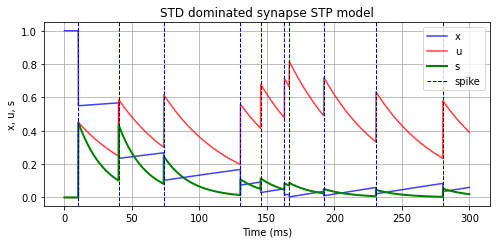

In [182]:
d, n, dt = 300, 3001, 0.1 # Preserve this numbers ALWAYS -> n=d*10+1
time_span = np.linspace(0,d,n)

X = np.zeros((3,n)) # x,u,s
X[0,0] = 1

std_params = {'taud':750, 'tauf':50, 'taus':20, 'af':0.45, 'A':1,}

spikes = spike_train(d, 30, dt)
for it,t in enumerate(time_span[:-1]):
    spike = it in (spikes*10).astype(int)        
    X[:,it+1] = time_step_stp(it, dt, X[:,it], X[:,it-1], spike, p) # Crappy euler integration

fig, ax = plt.subplots(1, figsize=(7,3.5))

plot_stp(ax, time_span, X, spikes, title='STD dominated synapse STP model')

fig.tight_layout()
fig.show()

Short Term Excitation temporal run

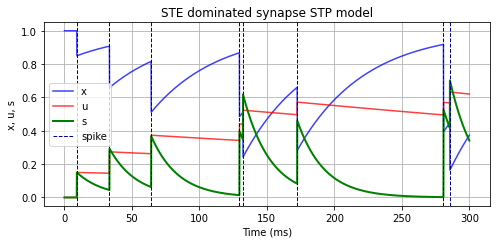

In [184]:
d, n, dt = 300, 3001, 0.1 # Preserve this numbers ALWAYS -> n=d*10+1
time_span = np.linspace(0,d,n)

X = np.zeros((3,n)) # x,u,s
X[0,0] = 1

ste_params = {'taud':50, 'tauf':750, 'taus':20, 'af':0.15, 'A':1,}

spikes = spike_train(d, 30, dt)
for it,t in enumerate(time_span[:-1]):
    spike = it in (spikes*10).astype(int)        
    X[:,it+1] = time_step_stp(it, dt, X[:,it], X[:,it-1], spike, std_params) # Crappy euler integration

fig, ax = plt.subplots(1, figsize=(7,3.5))

plot_stp(ax, time_span, X, spikes, title='STE dominated synapse STP model')

fig.tight_layout()
fig.show()

**Applying STP to the neuron model**

In [46]:
# global single cell parameters
ena, ek, el, esyn = 60, -90, -80, 0
gna, gk, gl = 20, 10, 8 
C, I = 1, 0
vmaxm, vmaxn = -20, -25
km, kn = 15, 5
taun, taus = 1, 5 

# global two cell parameters
vt, vs = 2, 5
As = 1
b1, b2 = 0.25, 0.1
I1, I2 = 0, 0
# g_ext, g_exc, g_inh = 3, 1, 0.1

In [100]:
# Excitation functions
def spike_train(d, rate, dt):
    """ Generates Poisson delta train
    Params:
    d (int): duration in milliseconds of the train
    rate (int): how many firings per second (Hz)
    dt (float): time differential used in the simulation REPLACE THIS IS NOW D/N AS EVERYTHING ELSE!
    Returns:
    result (np.array) with the indexes of the spikes
    """
    n = int(d/dt)
    spikes = np.random.rand(n) < rate/1000*dt # We divide by 1000 bc rate is in Hz
    index = np.where(spikes)[0]
    return index*dt

def alfa(t):
    """ Enveloping function
    For each spike we fire one of these
    """
    return 1/taus**2*t*np.e**(-t/taus)

def step(t):
    """ Returns 0 if t less than 0
    """
    return 1 if t > 0 else 0

def opt_gsyn(t, train):
    """ Excitation function
    Takes a Poisson delta train and generates a sum of enveloping functions (alphas)
    """
    result = 0
    reduced_train = train[(train > (t-40)) & (train < t)]
    for it in reduced_train:
        result += alfa(t-it)*step(t-it)
    return result

# ODE time derivative and assistant functions
def minf(V):
    return 1/(1+np.e**(-(V-vmaxm)/km))

def ninf(V):
    return 1/(1+np.e**(-(V-vmaxn)/kn))

def fpre(v):
    return 1./(1 + np.e**(-(v-vt)/vs))

# Parametric time derivative (Add all the parameters you wanna play with in the arguments of the function)
def twoneurons(X, t, spikes, g_ext, g_inh, g_exc, I1=0, I2=0, cross=False, lamb=1):
    V1, V2, n1, n2, s1, s2 = X
    
    if cross:
        A,B=V2,V1
    else:
        A,B=V1,V2
   
    dV1dt = (I1 - gl*(V1-el) - gna*minf(V1)*(V1-ena) - gk*n1*(V1-ek) - g_inh*s2*(A - (-80)) - g_ext*opt_gsyn(t, spikes)*(A-0))/C # 
    dn1dt = (ninf(V1) - n1)/taun
    
    dV2dt = (I2 - gl*(V2-el) - gna*minf(V2)*(V2-ena) - gk*n2*(V2-ek) - g_exc*s1*(B - 0))/C
    dn2dt = (ninf(V2) - n2)/taun
    
    ds1dt = As * fpre(V1)*(1-s1) - lamb*b1*s1
    ds2dt = As * fpre(V2)*(1-s2) - lamb*b2*s2
    
    return np.array([dV1dt, dV2dt, dn1dt, dn2dt, ds1dt, ds2dt])
    

First run Euler integration on the two neuron model

In [101]:
# Euler integration of two neuron model
d, n, dt = 300, 3001, 0.1 # Preserve this numbers ALWAYS -> n=d*10+1
time_span = np.linspace(0,d,n)

X = np.zeros((6,n)) # x,u,s
X[0:2,0] = -66,-66

spikes = spike_train(d, 30, dt)

params = {'spikes': spikes,
          'g_ext': 2, 
          'g_exc': 0.5, 
          'g_inh': 0}

for it,t in enumerate(time_span[:-1]):
           
    X[:,it+1] = X[:,it] + twoneurons(X[:,it],t, **params)*dt # Crappy euler integration

y0 = [-66,-66,0,0,0,0]
run, obs = odeint(partial(twoneurons, **params), y0=y0, t=time_span, full_output=1)


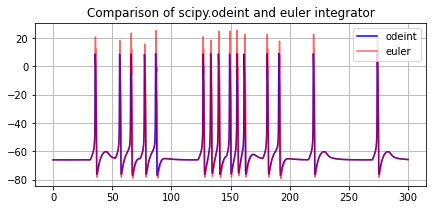

In [102]:
fig, axis = plt.subplots(1,1, figsize=(7,3))
axis.set_title('Comparison of scipy.odeint and euler integrator')
axis.plot(time_span, run[:,0], c='b', label='odeint')
axis.plot(time_span, X[0,:], c='r',alpha=0.6, label='euler')
axis.legend()
axis.grid()

In [96]:
# PLOT SET-UP
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter

def plot_spikesandgsyn(axis, spikes, time_span):
    # Plot spike lines
    for t in spikes:
        l1 = axis.axvline(x=t, color='darkblue', linestyle='dashed', linewidth=1, label='spike')

    # Compute synaptic excitation
    results = np.zeros(time_span.shape[0])
    for it, t in enumerate(time_span):
        results[it] = (opt_gsyn(t, spikes))

    # And plot it
    l2, = axis.plot(time_span,results, c='r', alpha=0.8, label='g_syn')

    # This is a custom legend (might export this to a function in the future)
    lines = [l1,l2]
    axis.legend(lines, [l.get_label() for l in lines])

    axis.set(ylabel="$g_{syn}$ (mS)",xlabel="time (ms)")
    axis.grid()
    
    return axis

def plot_neuron(axis, time_span, signals, n_num, set_time=False):
    
    # Plotting signal 1 in left axis and signal 2 in right axis
    l1, = axis.plot(time_span, signals[0] , c='tab:blue', label=f'$V_{{{n_num}}}$', lw=2.0)
    axis2 = axis.twinx()
    axis2.set(ylabel=f'$s_{{{n_num}}}$')
    l2, = axis2.plot(time_span, signals[1] , c='tab:orange', label=f'$s_{{{n_num}}}$', alpha=0.8)

    # This sets up the legend
    lines = [l1,l2]
    axis.legend(lines, [l.get_label() for l in lines])
    
    # Set labels
    axis.set(ylabel=f"$V_{{{n_num}}}$ (mv)")
    if set_time:
        axis.set(xlabel="time (ms)")
    
    # Activate grid
    axis.grid()

# Now a plot that actually means something
def plot_completetwoneurons(time_span, spikes, run, figsize=(7,7), title=None):
    fig, ax = plt.subplots(3,1, figsize=figsize, sharex=True, gridspec_kw={ 'height_ratios': [2, 2, 1],
                                                                      'wspace':0, 
                                                                      'hspace':0.2 })
    # This is to set same formatting (look good!)
    for a in ax: a.yaxis.set_major_formatter(FormatStrFormatter('%.2f')) 

    plot_spikesandgsyn(axis=ax[2], spikes=spikes, time_span=time_span)

    plot_neuron(axis=ax[0], time_span=time_span, signals=[run[:,0],run[:,4]], n_num=1)

    plot_neuron(axis=ax[1], time_span=time_span, signals=[run[:,1],run[:,5]], n_num=2)

    # Set big title
    pars = [f'{name}={params[name]}' for name in list(params.keys())[1:]]
    if title:
        fig.suptitle(title, y=0.93)
    else:    
        fig.suptitle(f'Temporal run two neuron model with {pars}', y=0.93)

    fig.tight_layout()
    
    return fig, ax

<ipython-input-96-538af7373829>:68: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


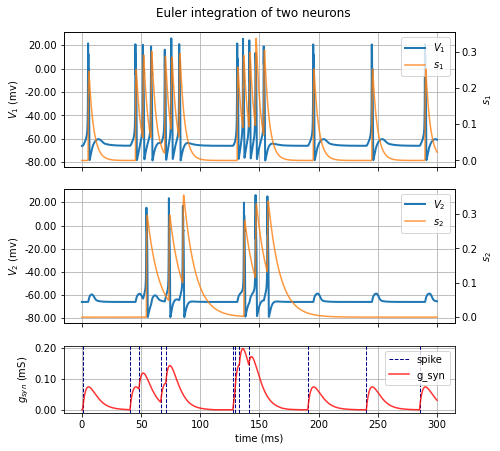

In [119]:
# Euler integration of two neuron model
d, n, dt = 300, 3001, 0.1 # Preserve this numbers ALWAYS -> n=d*10+1
time_span = np.linspace(0,d,n)

X = np.zeros((6,n)) # x,u,s
X[0:2,0] = -66,-66

load = True
if load:
    spikes = np.load('./data/nice_train.npy')
else:
    spikes = spike_train(d, 30, dt)
    
params = {'spikes': spikes,
          'g_ext': 2, 
          'g_exc': 0.5, 
          'g_inh': 0}

for it,t in enumerate(time_span[:-1]):
    X[:,it+1] = X[:,it] + twoneurons(X[:,it],t, **params)*dt # Crappy euler integration

y0 = [-66,-66,0,0,0,0]
run, obs = odeint(partial(twoneurons, **params), y0=y0, t=time_span, full_output=1)


plot_completetwoneurons(time_span, spikes, X.T, title='Euler integration of two neurons')

fig.show()

Now, add a spike detector to two neuron model

In [170]:
# Parametric time derivative (Add all the parameters you wanna play with in the arguments of the function)
def twoneurons_stp(X, t, spikes, g_ext, g_inh, g_exc, I1=0, I2=0, cross=False, lamb=1):
    V1, V2, n1, n2 = X[:4]
    s1, s2 = X[6], X[9]
    
    if cross:
        A,B=V2,V1
    else:
        A,B=V1,V2
    
    dV1dt = (I1 - gl*(V1-el) - gna*minf(V1)*(V1-ena) - gk*n1*(V1-ek) - g_inh*s2*(A - (-80)) - g_ext*opt_gsyn(t, spikes)*(A-0))/C # 
    dn1dt = (ninf(V1) - n1)/taun
    
    dV2dt = (I2 - gl*(V2-el) - gna*minf(V2)*(V2-ena) - gk*n2*(V2-ek) - g_exc*s1*(B - 0))/C
    dn2dt = (ninf(V2) - n2)/taun
    
    return np.array([dV1dt, dV2dt, dn1dt, dn2dt])

In [205]:
def plot_completetwoneurons_stp(time_span, spikes, run, figsize=(7,7), title=None):
    fig, ax = plt.subplots(3,1, figsize=figsize, sharex=True, gridspec_kw={ 'height_ratios': [2, 2, 1],
                                                                      'wspace':0, 
                                                                      'hspace':0.2 })
    # This is to set same formatting (look good!)
    for a in ax: a.yaxis.set_major_formatter(FormatStrFormatter('%.2f')) 

    plot_spikesandgsyn(axis=ax[2], spikes=spikes, time_span=time_span)

    plot_neuron(axis=ax[0], time_span=time_span, signals=[run[:,0],run[:,6]], n_num=1)

    plot_neuron(axis=ax[1], time_span=time_span, signals=[run[:,1],run[:,9]], n_num=2)

    # Set big title
    pars = [f'{name}={params[name]}' for name in list(params.keys())[1:]]
    if title:
        fig.suptitle(title, y=0.93)
    else:    
        fig.suptitle(f'Temporal run two neuron model with STP', y=0.93)

    fig.tight_layout()
    
    return fig, ax

In [206]:
a = [0,1,2,3,4,5,6,7,8,9]

<ipython-input-205-4436cc076992>:21: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


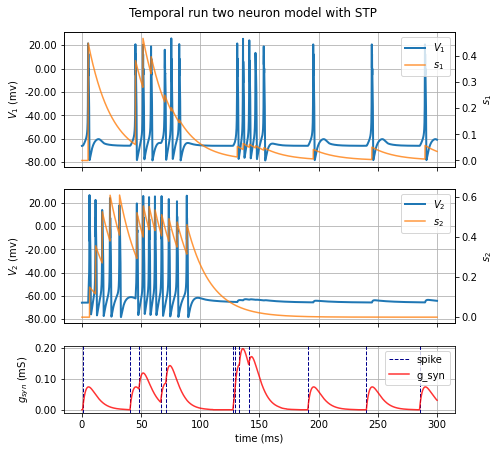

In [207]:
# Euler integration of two neuron model
d, n, dt = 300, 3001, 0.1 # Preserve this numbers ALWAYS -> n=d*10+1
time_span = np.linspace(0,d,n)

                     # 0, 1, 2, 3, 4, 5, 6, 7, 8, 9
X = np.zeros((10,n)) # v1,v2,n1,n2,x1,u1,s1,x2,u2,s2
X[0:2,0] = -66,-66
X[4,0], X[7,0] = 1, 1

load = True
if load:
    spikes = np.load('./data/nice_train.npy')
else:
    spikes = spike_train(d, 30, dt)
    
params = {'spikes': spikes,
          'g_ext': 2, 
          'g_exc': 1, 
          'g_inh': 0}

std_params = {'taud':750, 'tauf':50, 'taus':20, 'af':0.45, 'A':1,}
ste_params = {'taud':50, 'tauf':750, 'taus':20, 'af':0.15, 'A':1,}


for it,t in enumerate(time_span[:-1]):
    sp1 = (X[0,it]>10) and (X[0,it-5:it]<10).all()
    sp2 = (X[1,it]>10) and (X[1,it-5:it]<10).all()
    
    X[4:7,it+1] = time_step_stp(it, dt, X[4:7,it], X[4:7,it-1], sp1, std_params) # Crappy euler integration
    X[7:10,it+1] = time_step_stp(it, dt, X[7:10,it], X[7:10,it-1], sp2, ste_params) # Crappy euler integration

    X[:4,it+1] = X[:4,it] + twoneurons_stp(X[:,it], t, **params)*dt # Crappy euler integration
    

y0 = [-66,-66,0,0,0,0]
run, obs = odeint(partial(twoneurons, **params), y0=y0, t=time_span, full_output=1)

plot_completetwoneurons_stp(time_span, spikes, X.T)

fig.show()